In [1]:
#imports
from __future__ import print_function
import sys
import os
import psutil
import math
import numpy as np
import pandas as pd
import cv2 as cv
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import statsmodels.api as sm
import statistics as stats

mpl.rcParams['figure.dpi'] = 300
pd.set_option('display.max_columns', None)  

path_to_db = "/home/devreckas/Google-Drive/Wheeler-Labs/Personal_Work/fb-pruner/fb-pruner/accessories/"

In [2]:
# index filepaths
target_index_fname = ""
query_index_fname = ""

In [3]:
# data filepaths
hmmer_generic_fname = "{}/min5k/results/hmmer.min5k.csv".format(path_to_db)
mmseqs_plus_fname = "{}/min5k/results/cloud-results.min5k.csv".format(path_to_db)

#### Indexes

In [ ]:
# set header format
target_index_dformat = {
    "target_id": "int64",
    "target_offset": "int64",
    "target_name": "str"
}
query_index_dformat = {
    "query_id": "int64",
    "query_offset": "int64",
    "query_name": "str"
}
target_index_header = target_index_dformat.keys()
query_index_header = query_index_dformat.keys()

In [ ]:
# load target data
usecols = [0,2]
skiprows = None
sep = "\t"
names = target_index_header
target_index = pd.read_csv( target_index_fname, sep=sep, header=None, skiprows=skiprows, usecols = usecols, names=names, index_col=False, verbose=False )
target_index

In [ ]:
# load query data
usecols = [0,2]
skiprows = None
sep = "\t"
names = query_index_header
query_index = pd.read_csv( query_index_fname, sep=sep, header=None, skiprows=skiprows, usecols = usecols, names=names, index_col=False, verbose=False )
query_index

#### HMMER data

In [ ]:
# set header names and datatype
hmmer_generic_dformat = {
#     "header_id": "str", 
    "target_length": "int64",
    "target_name": "str",
    
    "query_length": "int64", 
    "query_name": "str", 
    
    "forward_gen_time": "float64", 
    "forward_gen_score": "float64", 
    "forward_opt_time": "float64",
    "forward_opt_score": "float64",
    "sequence_score": "float64"
}
hmmer_generic_header = hmmer_generic_dformat.keys()

In [ ]:
# load data
sep = " "
usecols = [0,1,2,3,4,5,6,7,8]
skiprows = []
names = hmmer_generic_header
hmmer_generic_data = pd.read_csv( hmmer_generic_fname, sep=" ", header=None, skiprows=skiprows, usecols = usecols, names=names, index_col=False, verbose=False )
hmmer_generic_data

In [ ]:
# cast data to proper datatypes
cols = list(hmmer_generic_data.columns.values)
for i in range(len(cols)):
    col = cols[i]
    dtype = hmmer_generic_dformat[col]
    hmmer_generic_data.iloc[:,i] = hmmer_generic_data.iloc[:,i].astype(dtype)
hmmer_generic_data.dtypes

In [ ]:
# # add target and query id's
# key = 'target_name'
# hmmer_generic_data = hmmer_generic_data.merge( target_index, how='inner', left_on=key, right_on=key)
# key = 'query_name'
# hmmer_generic_data = hmmer_generic_data.merge( query_index, how='inner', left_on=key, right_on=key)
# hmmer_generic_data.dtypes

#### MMseqs Plus data

In [4]:
# set header names and datatype
mmseqs_plus_dformat = {
    "target_id": "int64", 
    "target_length": "int64", 
    "target_name": "str",
    
    "query_id": "int64", 
    "query_length": "int64", 
    "query_name": "str",
    
    "total_cells": "int64", 
    "cloud_cells": "int64", 
    
    "viterbi_time": "float64",
    "viterbi_score": "float64", 
    "forward_time": "float64",
    "forward_score": "float64", 
    "cloud_time": "float64",
    "cloud_score": "float64",
    
    "alpha": "float64", 
    "alpha_max": "float64"
}
mmseqs_plus_header = mmseqs_plus_dformat.keys()

In [5]:
# load mmseqs data 
sep = " "
usecols = range(len(mmseqs_plus_dformat))
skiprows = []
names = mmseqs_plus_header
mmseqs_plus_data = pd.read_csv( mmseqs_plus_fname, sep=sep, header=None, skiprows=skiprows, usecols=usecols, names=names, index_col=False, verbose=False )
mmseqs_plus_data

,target_id,target_length,target_name,query_id,query_length,query_name,total_cells,cloud_cells,viterbi_time,viterbi_score,forward_time,forward_score,cloud_time,cloud_score,alpha,alpha_max
0,0,9535,targetdb.min5k.1,0,6486,O30409_1_a.28.1.2_|3.8e-35_|d2gdwa1_|1-76_|303...,61860032,920,3.443037,-21.306253,5.623034,-14.023836,0.003075,-19.040165,8,8
1,0,9535,targetdb.min5k.1,1,13711,H0VZZ7_1_d.144.1.7_|3.4e-170_|d1tkia__|1-321_|...,130757632,1616,7.085934,-21.762016,12.294182,-13.632969,0.004568,-17.511646,8,8
2,0,9535,targetdb.min5k.1,2,8081,O01761_1_b.55.1.1_|3e-64_|d1fhoa__|2-119_|341-...,77069952,1941,4.194228,-18.471920,7.337298,-10.788845,0.005095,-13.000050,8,8
3,0,9535,targetdb.min5k.1,3,9535,Q2FYJ6_1_a.8.1.2_a.8.1.2_|4.5e-31_2e-23_|d1xvh...,90935296,39876,4.945244,345.758972,8.355143,937.072998,0.057200,310.995697,8,8
4,0,9535,targetdb.min5k.1,4,18095,M9PC48_1_g.3.18.1_|1.5e-07_|d1oiga__|1-24_|924...,172563456,1261,9.371878,-21.427429,16.764733,-15.741810,0.010755,-18.465633,8,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,4,18095,targetdb.min5k.5,1,13711,H0VZZ7_1_d.144.1.7_|3.4e-170_|d1tkia__|1-321_|...,248132352,14173,13.435291,-19.892057,22.634746,-14.470898,0.014299,-16.454033,22,34
956,4,18095,targetdb.min5k.5,2,8081,O01761_1_b.55.1.1_|3e-64_|d1fhoa__|2-119_|341-...,146251872,13699,7.920655,-21.616116,13.308641,-14.186207,0.015421,-18.834877,22,34
957,4,18095,targetdb.min5k.5,3,9535,Q2FYJ6_1_a.8.1.2_a.8.1.2_|4.5e-31_2e-23_|d1xvh...,172563456,30012,9.362703,-18.082973,15.926126,-11.508261,0.018290,-11.683487,22,34
958,4,18095,targetdb.min5k.5,4,18095,M9PC48_1_g.3.18.1_|1.5e-07_|d1oiga__|1-24_|924...,327465216,1863442,17.670163,347.309906,30.089066,1804.338623,1.024521,1804.338623,22,34


In [6]:
# add hmmer_scores
key = ['target_length','query_length']
mmseqs_plus_data = mmseqs_plus_data.merge( hmmer_generic_data, how='inner', left_on=key, right_on=key)
mmseqs_plus_data.dtypes

NameError: name 'hmmer_generic_data' is not defined

In [7]:
# add difference of alpha and alpha_max
mmseqs_plus_data["max_drop"] = mmseqs_plus_data.alpha_max - mmseqs_plus_data.alpha
mmseqs_plus_data.max_drop

0       0
1       0
2       0
3       0
4       0
       ..
955    12
956    12
957    12
958    12
959    12
Name: max_drop, Length: 960, dtype: int64

In [8]:
## PLOT score v. alpha params
alphas = mmseqs_plus_data.alpha.unique()
max_drops = mmseqs_plus_data.max_drop.unique()
sizes = mmseqs_plus_data.total_cells.unique()
t_ids = mmseqs_plus_data.target_id.unique()
q_ids = mmseqs_plus_data.query_id.unique()

pair_ids = [(t,q) for t in t_ids for q in q_ids]
print(pair_ids)

cld_sc = {}
vit_sc = {}
fwd_sc = {}
fwd_gen_sc = {}
fwd_opt_sc = {}

cld_tm = {}
vit_tm = {}
fwd_tm = {}
fwd_gen_tm = {}
fwd_opt_tm = {}

cloud_cells = {}
total_cells = {}

mmseqs_plus_data = mmseqs_plus_data.sort_values(by=['alpha'])

for pair in pair_ids:
    
    sub_data = mmseqs_plus_data[(mmseqs_plus_data.target_id == pair[0]) & (mmseqs_plus_data.query_id == pair[1])]
    
    cld_sc[pair] = {}
    cld_tm[pair] = {}
    
    vit_sc[pair] = {}
    vit_tm[pair] = {}
    
    fwd_sc[pair] = {}
    fwd_tm[pair] = {}
    
    fwd_gen_sc[pair] = {}
    fwd_gen_tm[pair] = {}
    
    cloud_cells[pair] = {}
    total_cells[pair] = {}
    
    for max_drop in max_drops:

        sub2_data = sub_data[sub_data.max_drop == max_drop]

        cld_sc[pair][max_drop] = sub2_data.cloud_score
        cld_tm[pair][max_drop] = sub2_data.cloud_time
        
        cloud_cells[pair][max_drop] = sub2_data.cloud_cells
        total_cells[pair][max_drop] = sub2_data.total_cells

        vit_sc[pair][max_drop] = sub2_data.viterbi_score
        vit_tm[pair][max_drop] = sub2_data.viterbi_time
        
        fwd_sc[pair][max_drop] = sub2_data.forward_score
        fwd_tm[pair][max_drop] = sub2_data.forward_time
        
#         fwd_gen_sc[pair][max_drop] = sub2_data.forward_opt_score
#         fwd_gen_tm[pair][max_drop] = sub2_data.forward_opt_time
        

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5)]


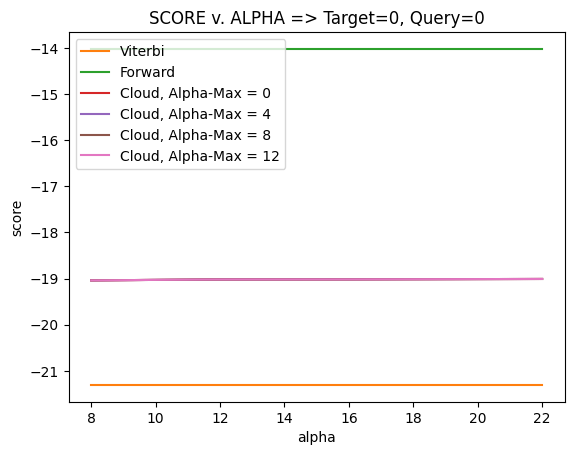

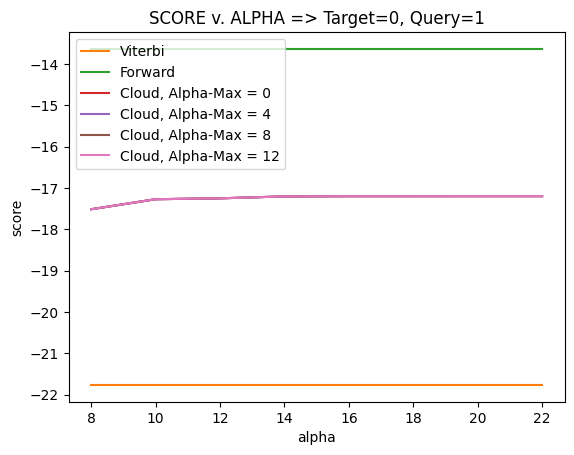

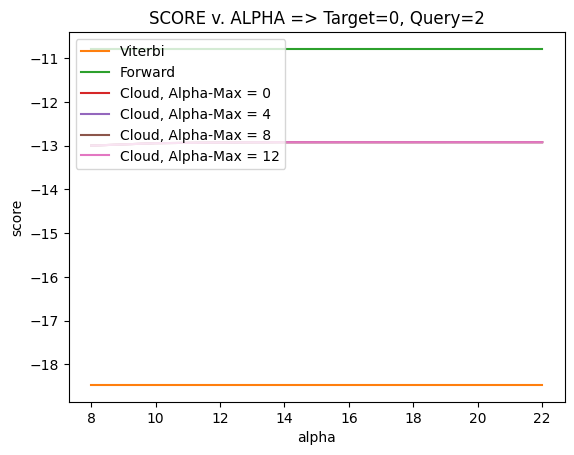

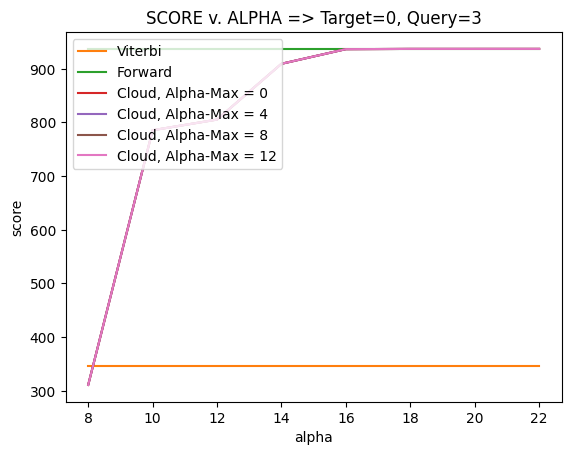

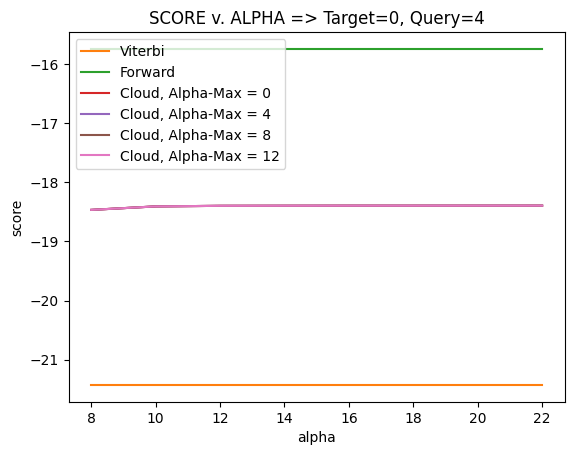

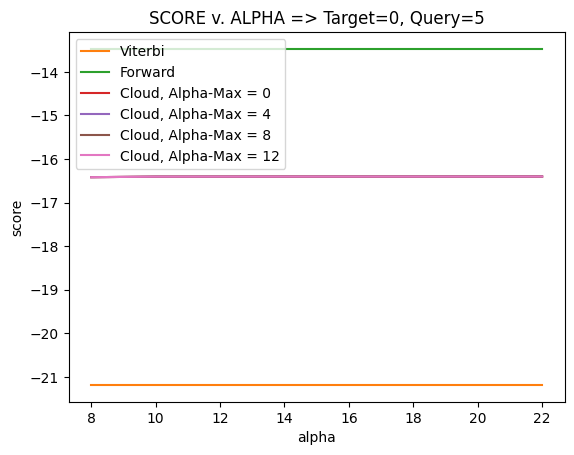

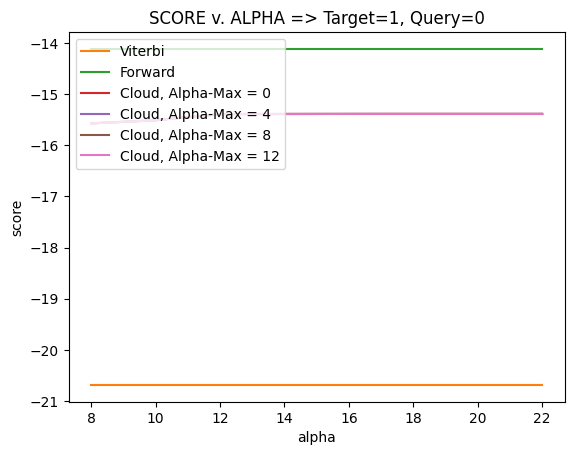

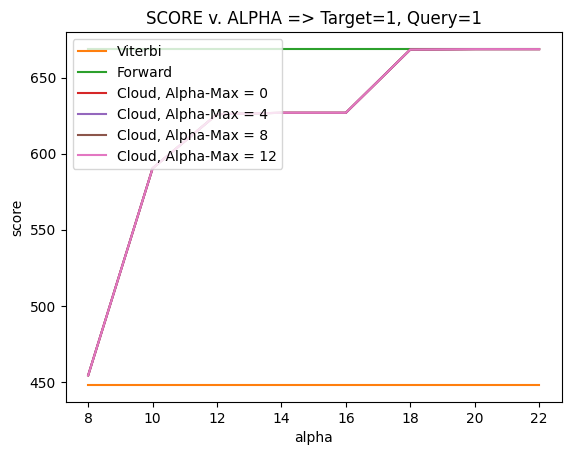

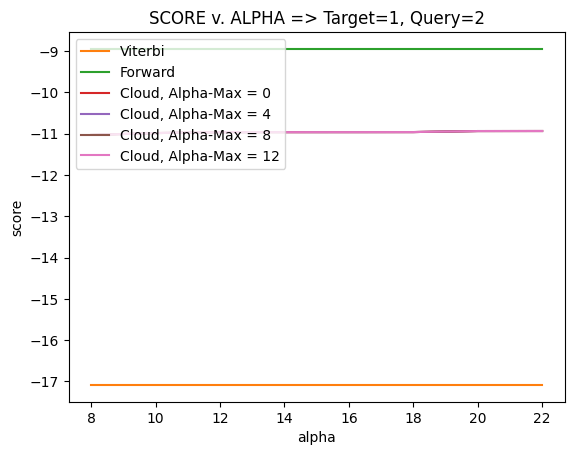

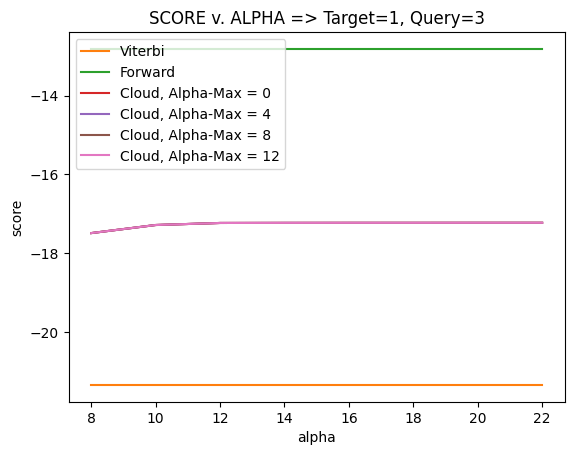

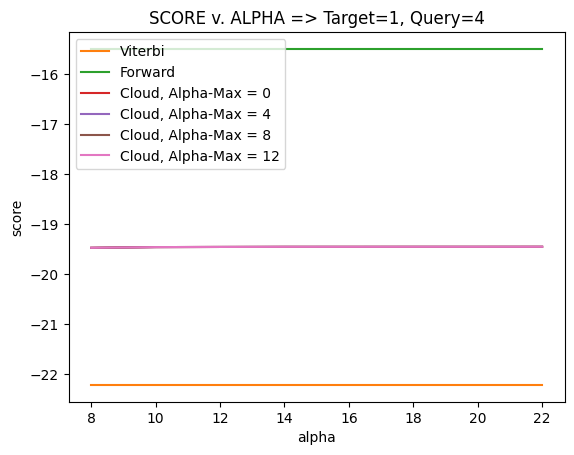

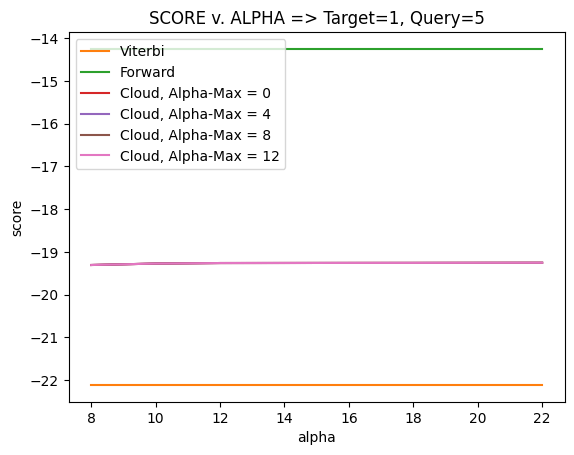

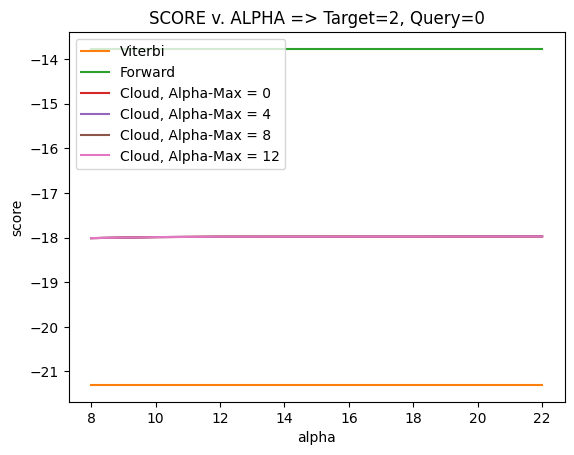

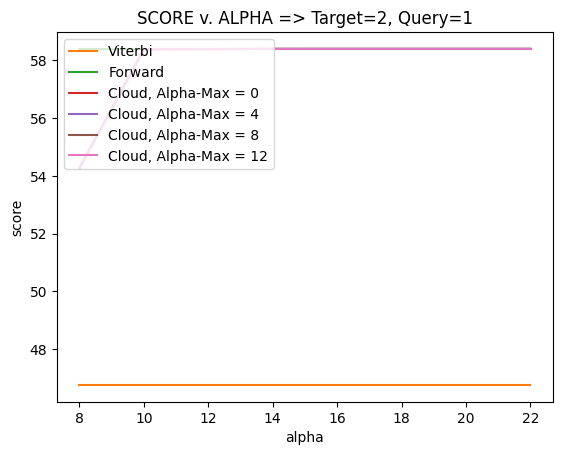

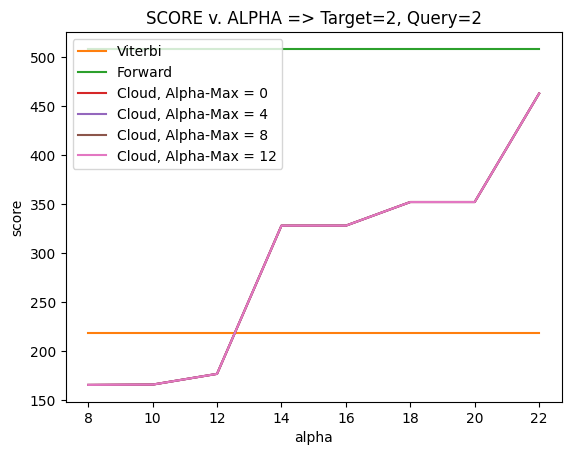

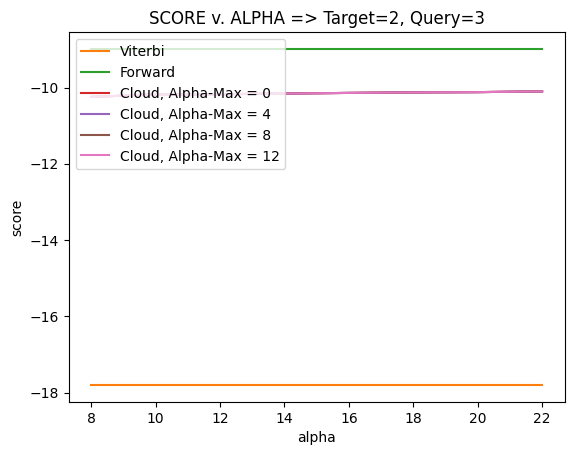

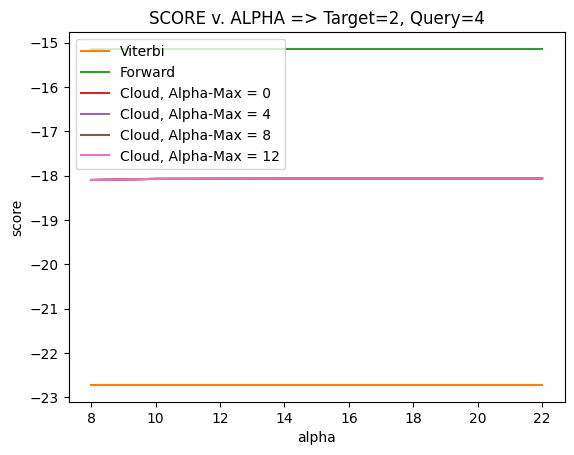

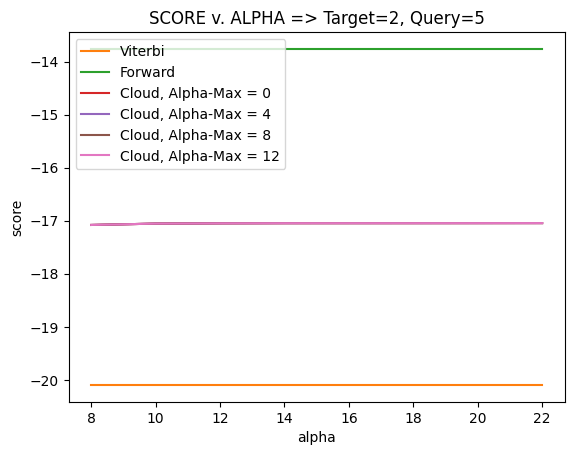

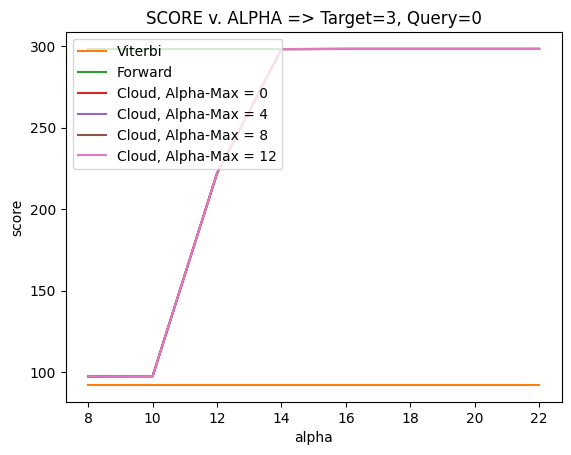

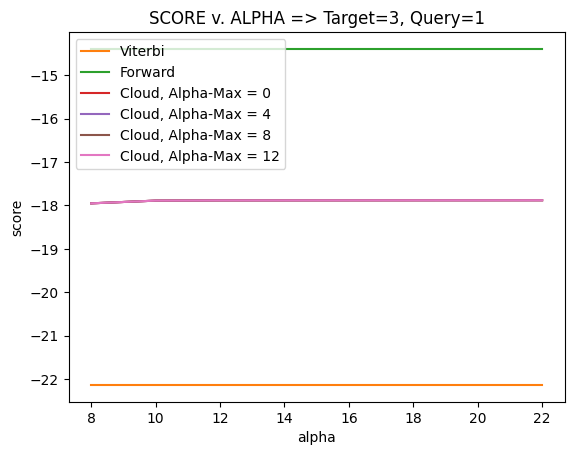

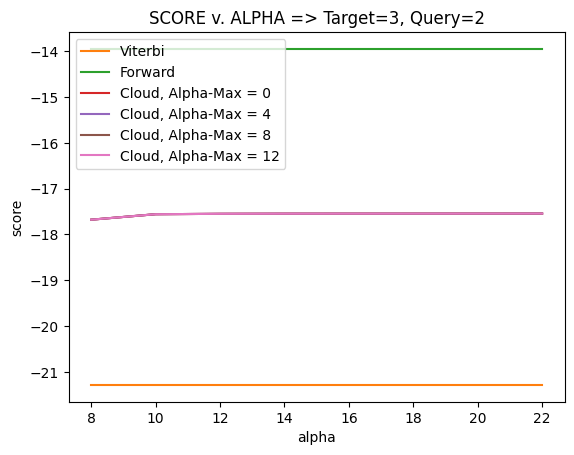

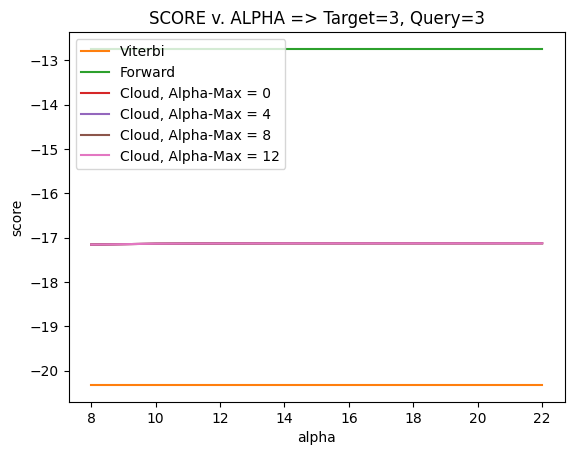

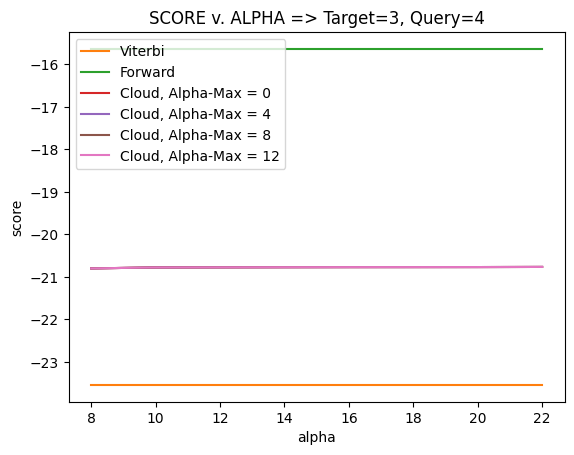

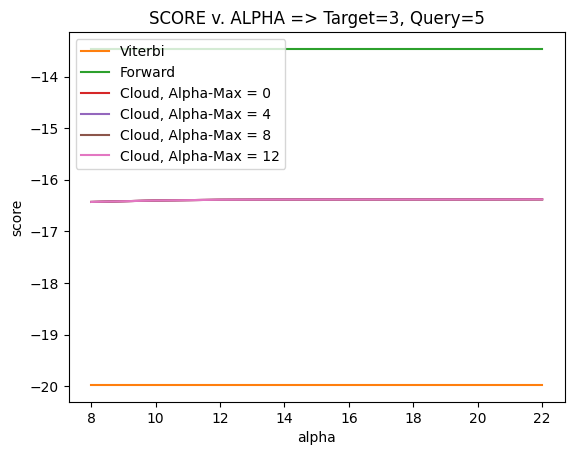

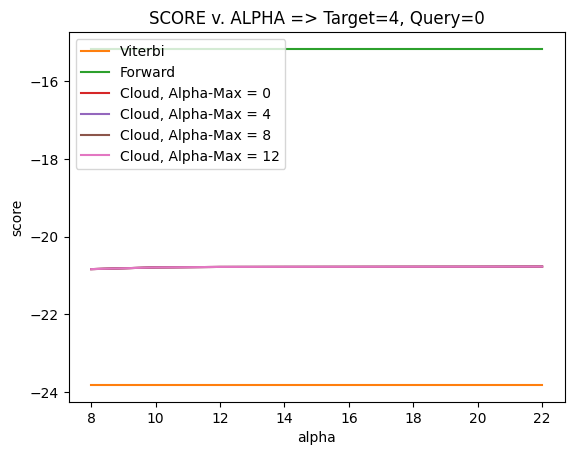

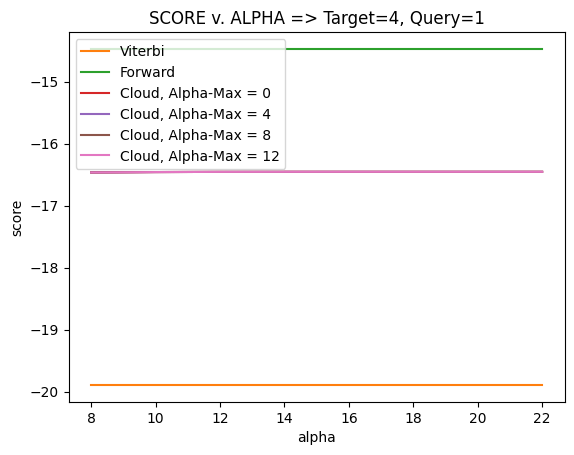

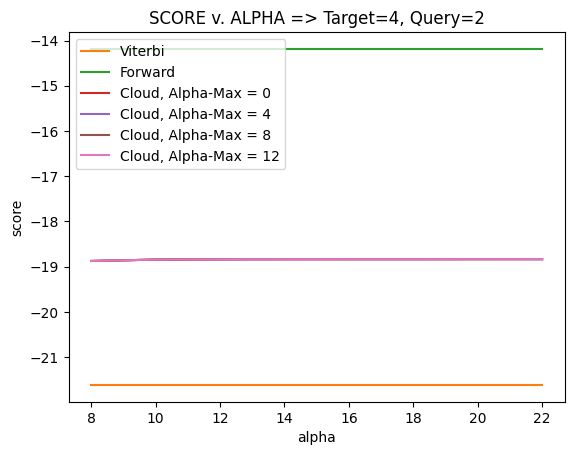

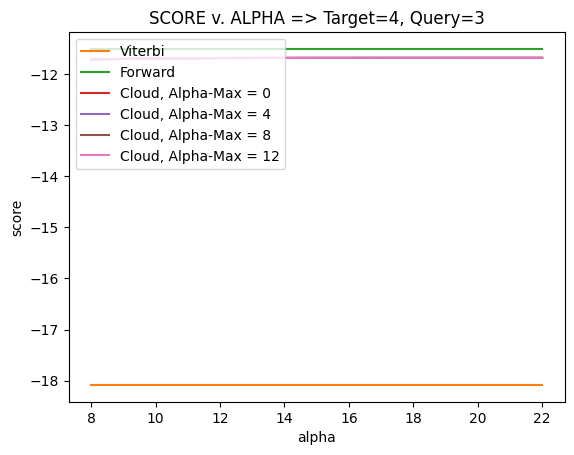

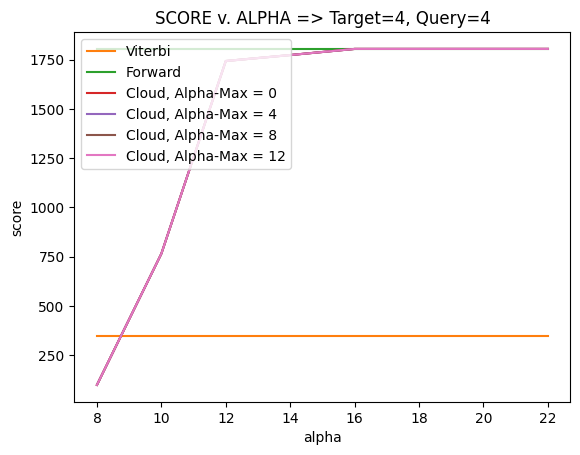

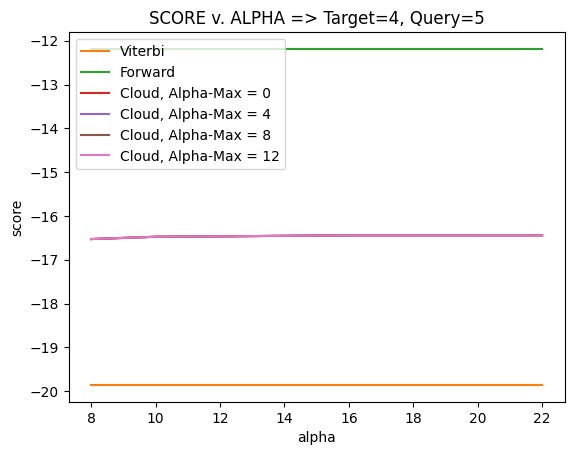

In [9]:
# PLOT: size v. alpha
mpl.style.use('default')

p_id = 3

for p_id in range(len(pair_ids)):
    pair = pair_ids[p_id]
    c = 2
    colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
    i = 0

    plt.plot( alphas, vit_sc[pair_ids[p_id]][max_drops[0]], 'C1', label='Viterbi' )
    plt.plot( alphas, fwd_sc[pair_ids[p_id]][max_drops[0]], 'C2', label='Forward' )
    for max_drop in max_drops:
        plt.plot( alphas, cld_sc[pair_ids[p_id]][max_drop], colors[c], label='Cloud, Alpha-Max = {}'.format(max_drop) )
        c += 1

    plt.title('SCORE v. ALPHA => Target={}, Query={}'.format(pair[0],pair[1]))
    plt.legend(loc='upper left')
    plt.xlabel('alpha')
    plt.ylabel('score')
    plt.show()

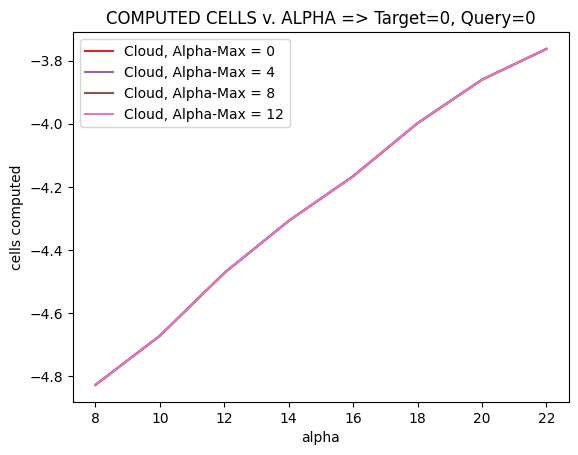

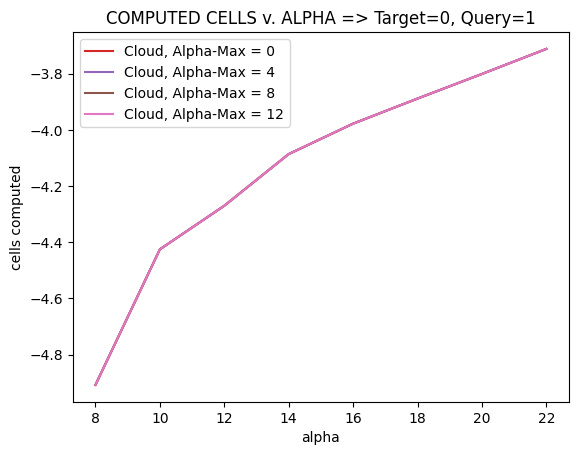

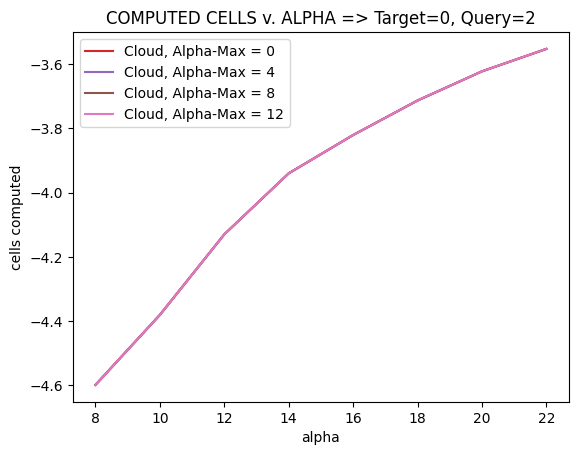

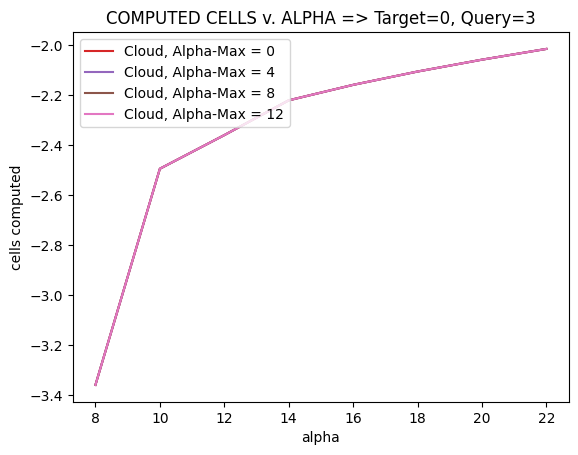

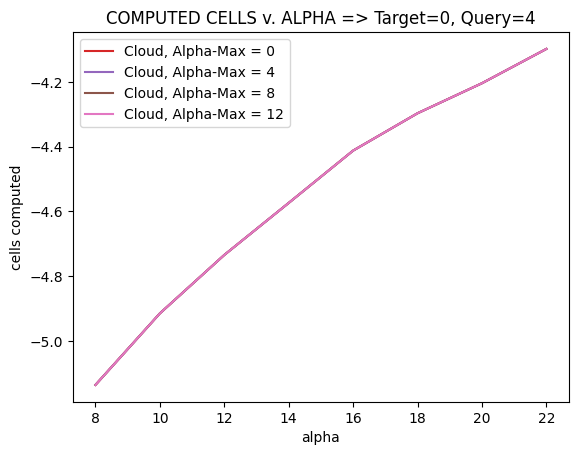

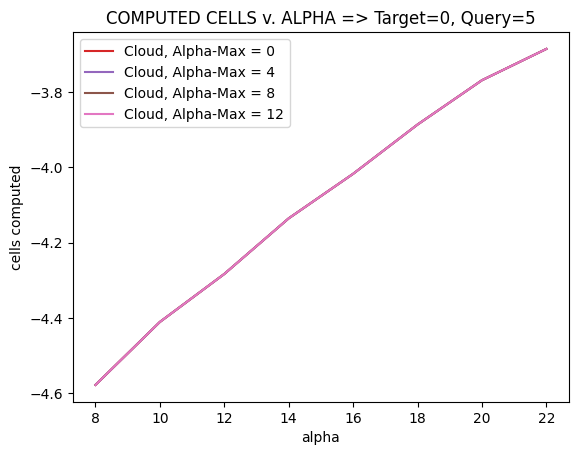

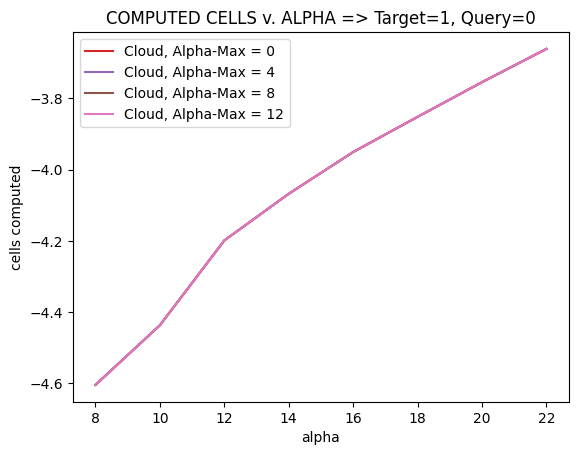

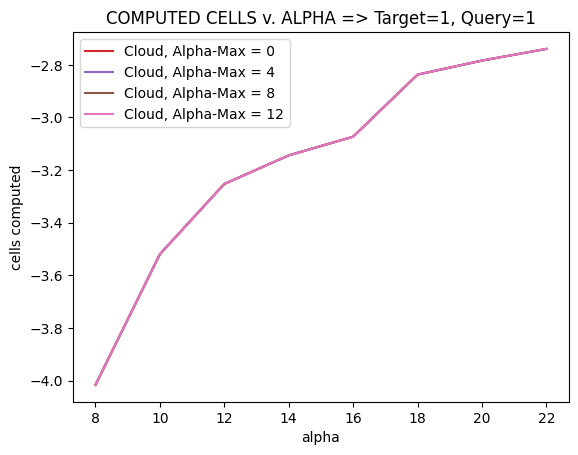

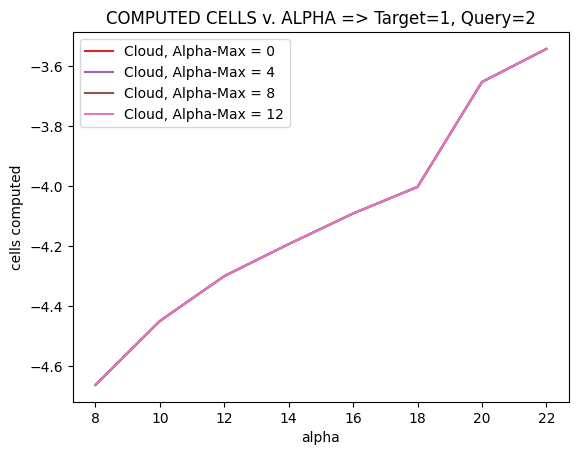

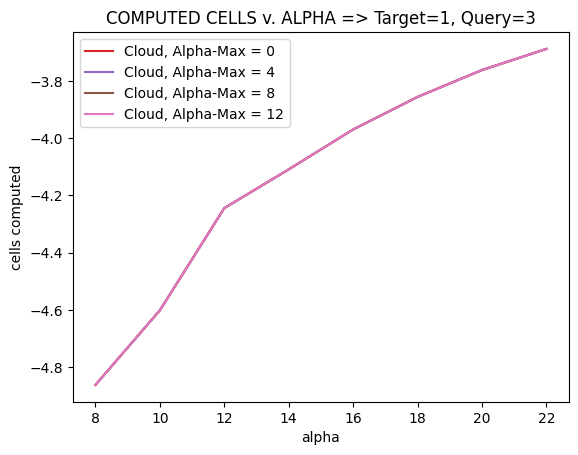

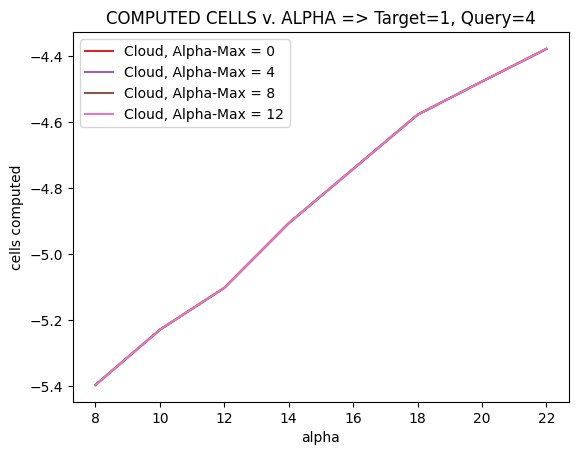

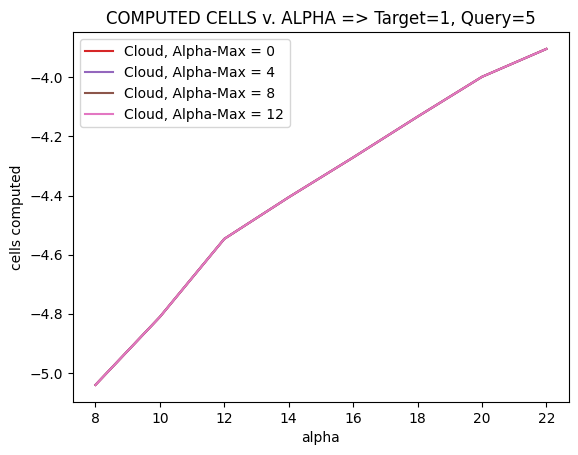

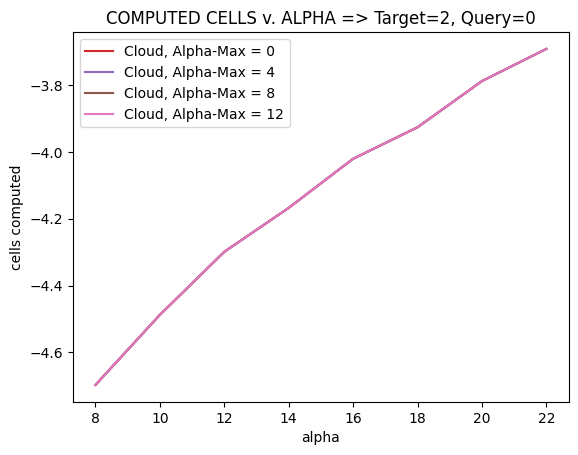

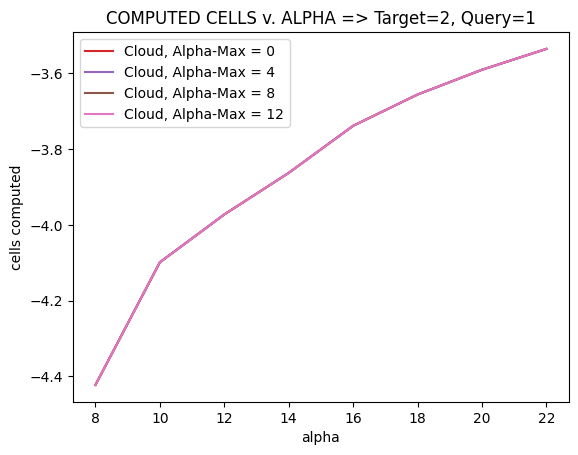

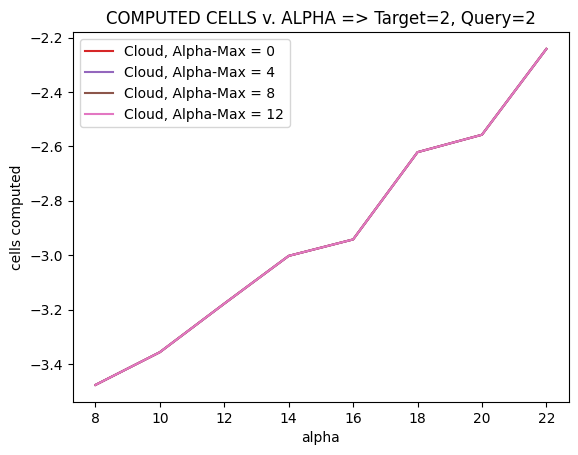

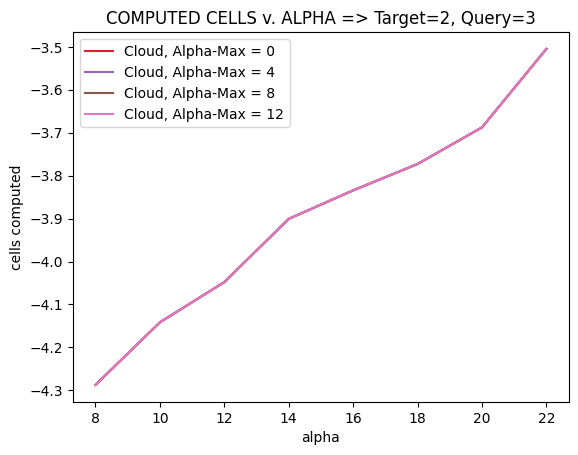

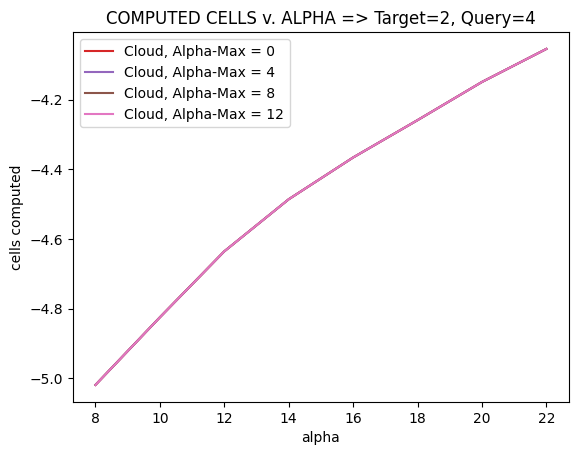

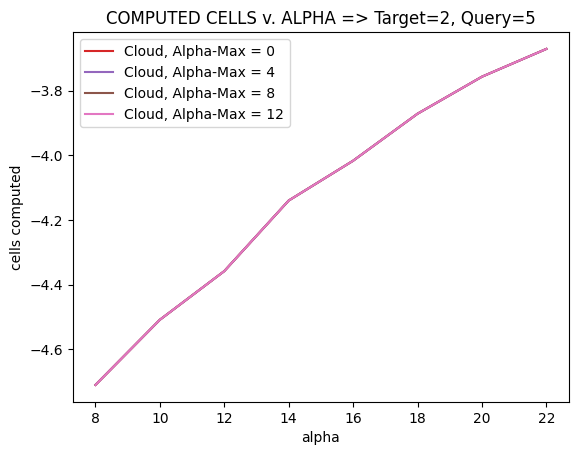

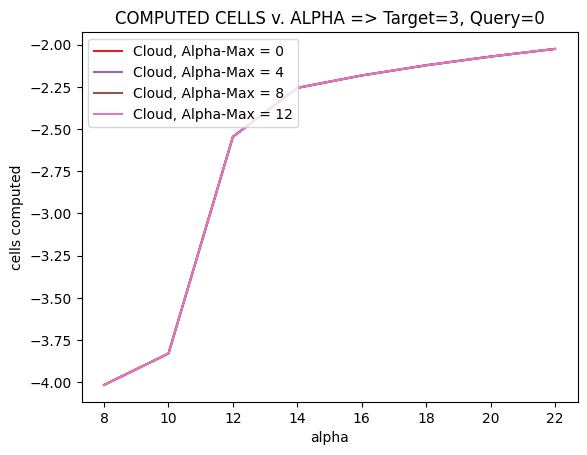

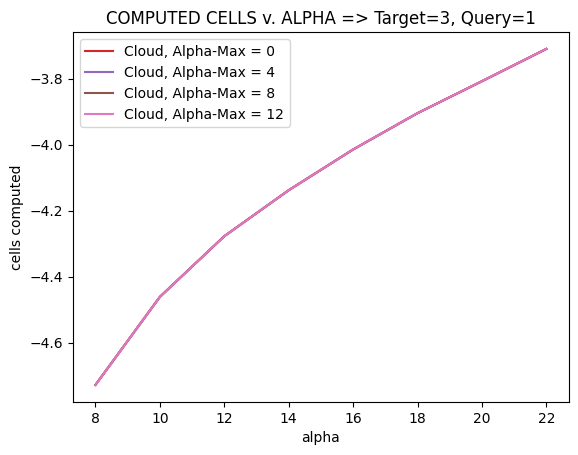

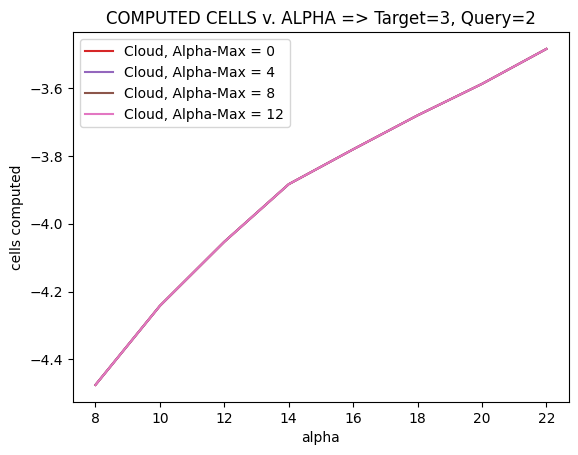

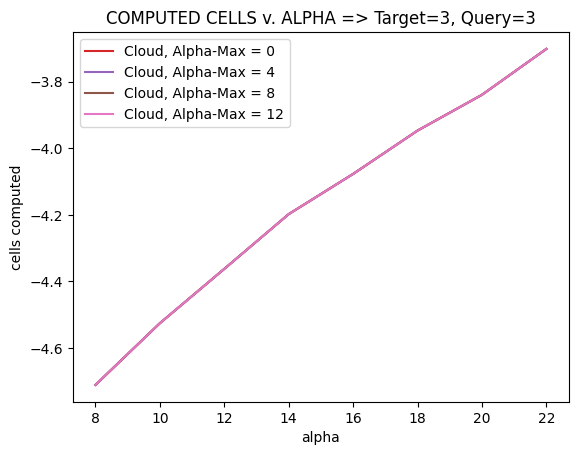

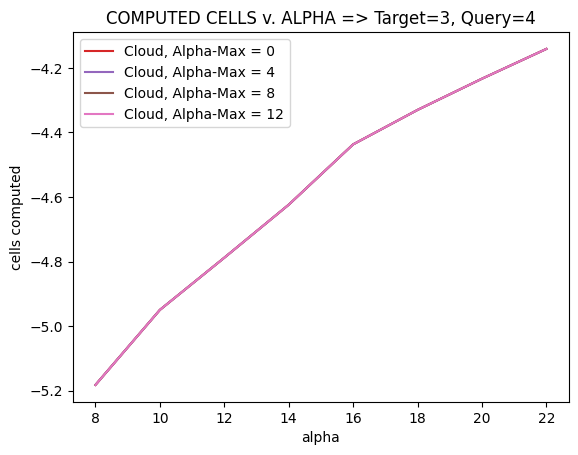

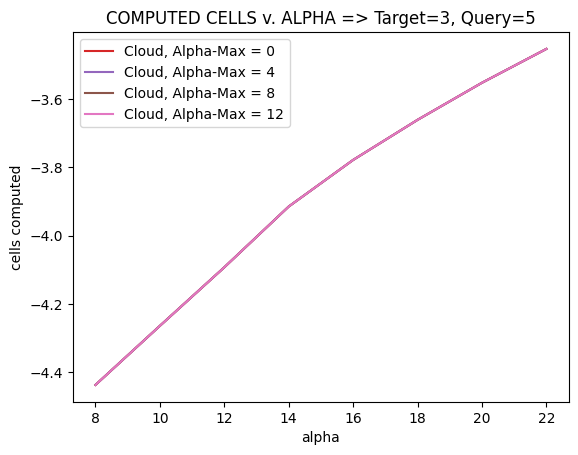

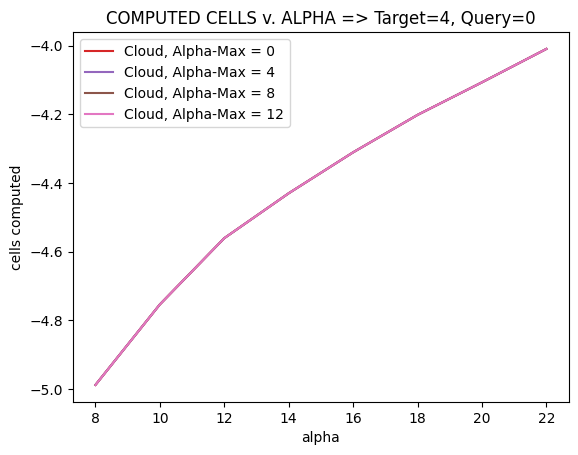

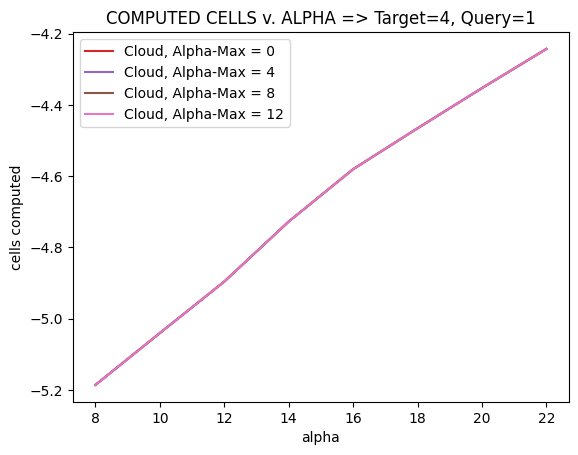

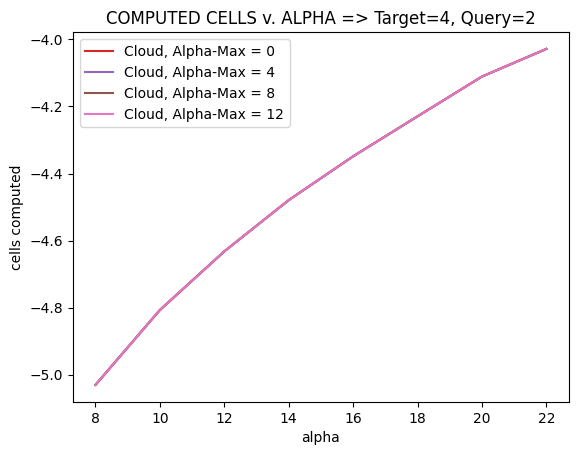

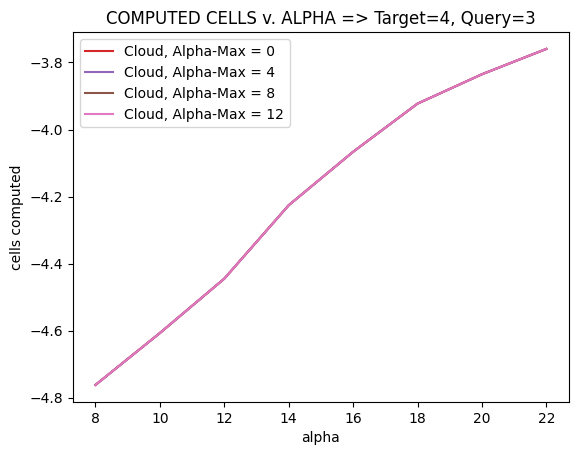

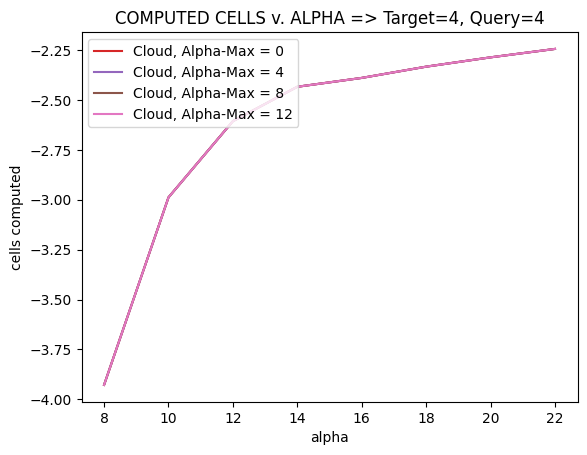

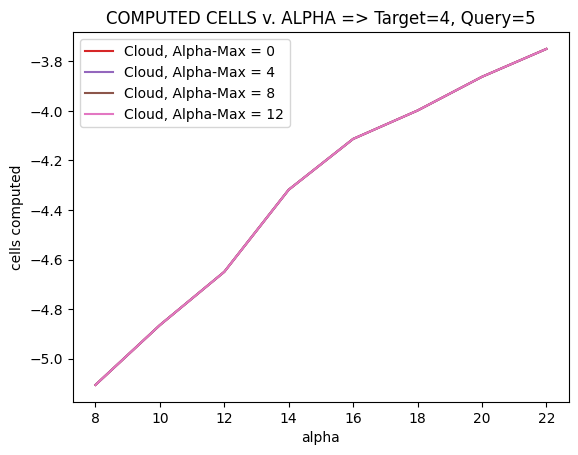

In [17]:
# PLOT computed cells v. alpha
mpl.style.use('default')

p_id = 3

for p_id in range(len(pair_ids)):
    pair = pair_ids[p_id]
    c = 2
    colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
    i = 0

#     plt.plot( alphas, np.log10(total_cells[pair_ids[p_id]][max_drops[0]]), 'C1', label='Total Cells' )
    for max_drop in max_drops:
        plt.plot( alphas, np.log10(cloud_cells[pair_ids[p_id]][max_drop]/total_cells[pair_ids[p_id]][max_drop]), colors[c], label='Cloud, Alpha-Max = {}'.format(max_drop) )
        c += 1

    plt.title('COMPUTED CELLS v. ALPHA => Target={}, Query={}'.format(pair[0],pair[1]))
    plt.legend(loc='upper left')
    plt.xlabel('alpha')
    plt.ylabel('cells computed')
    plt.show()

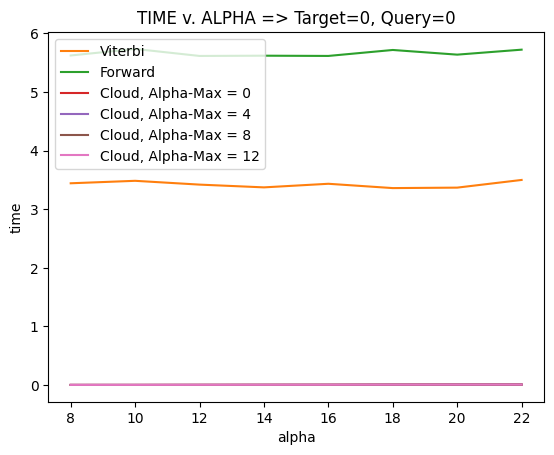

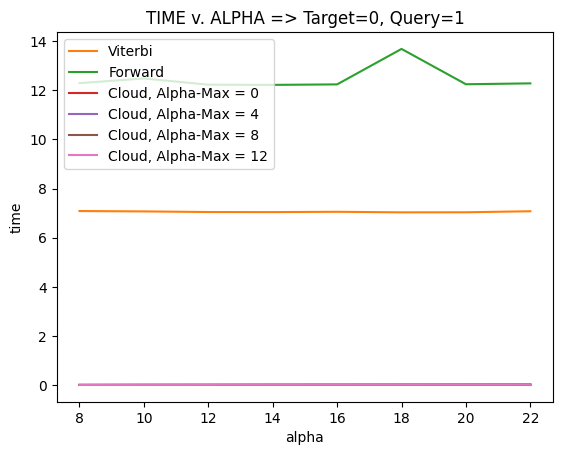

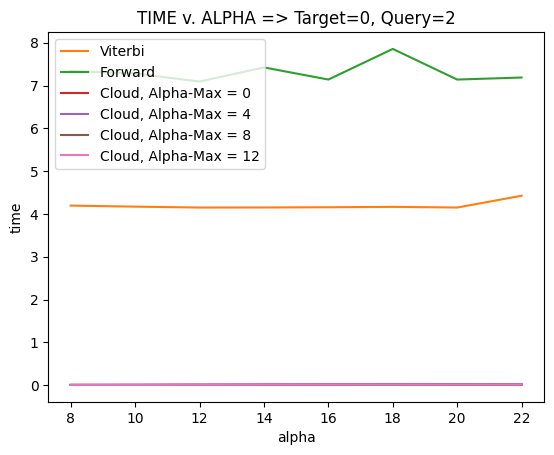

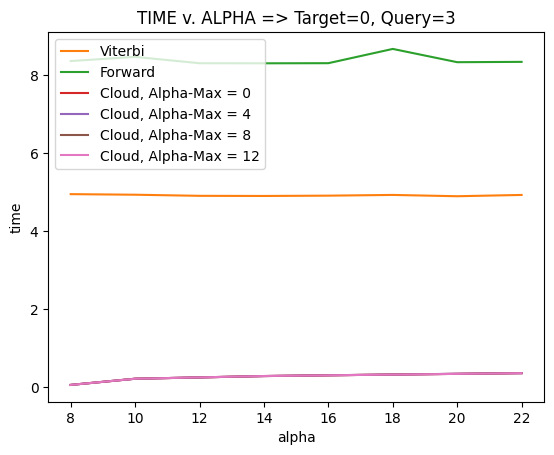

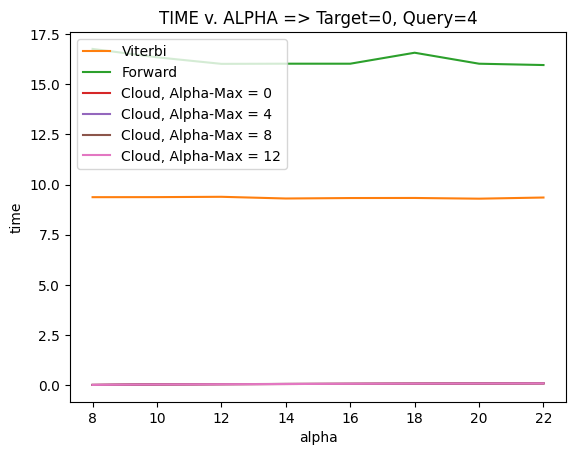

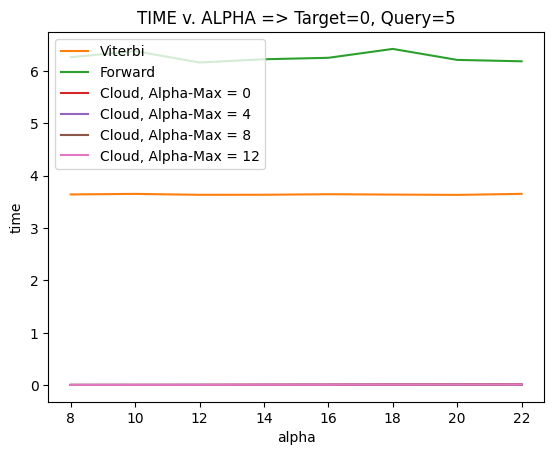

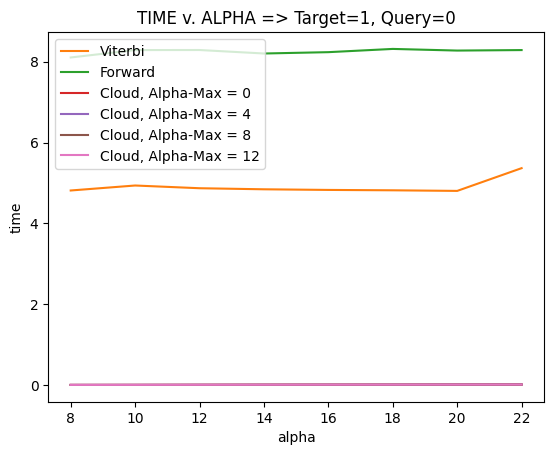

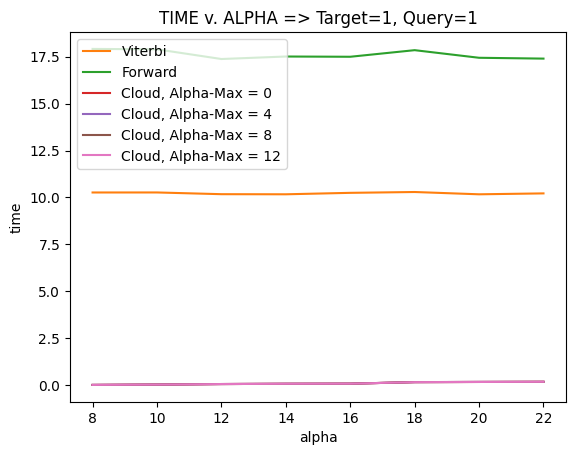

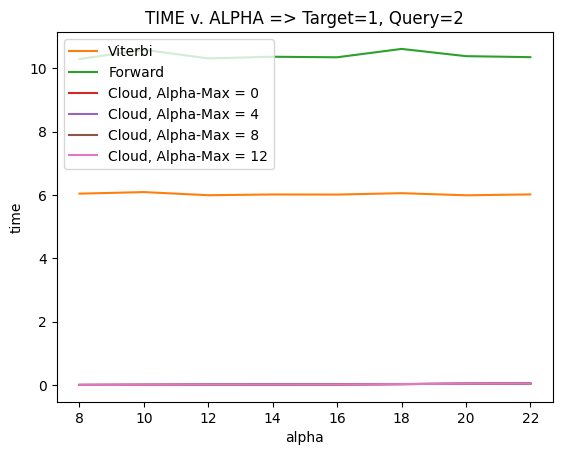

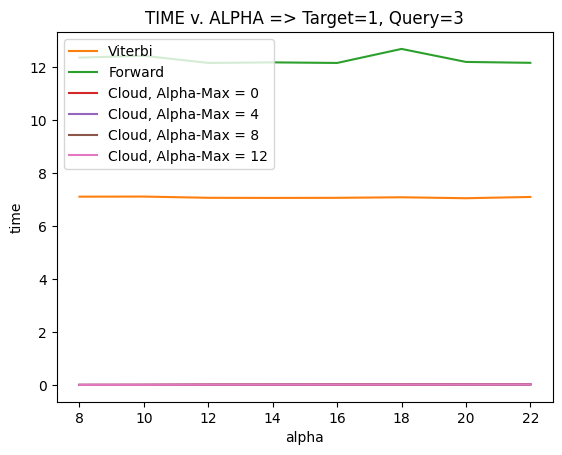

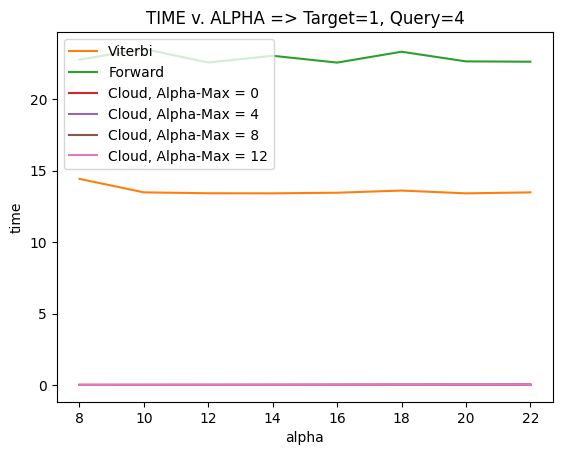

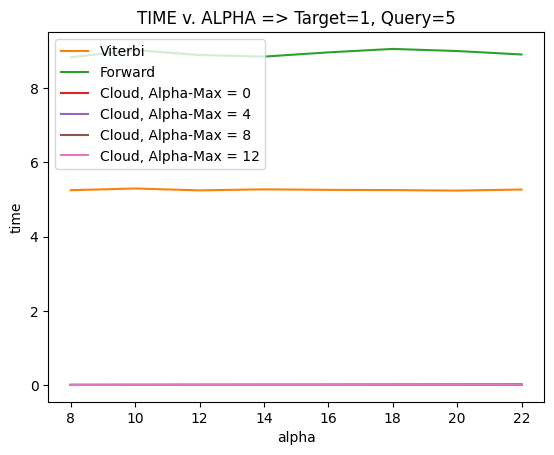

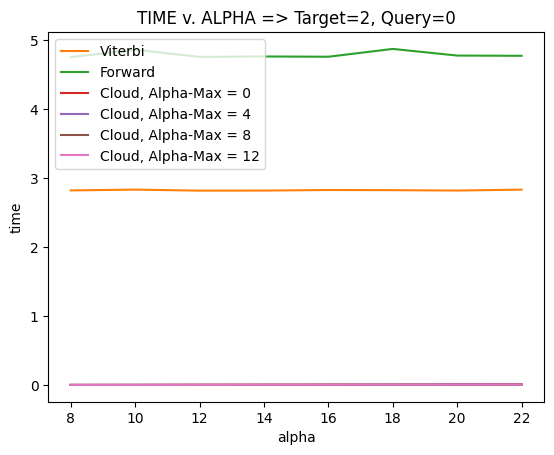

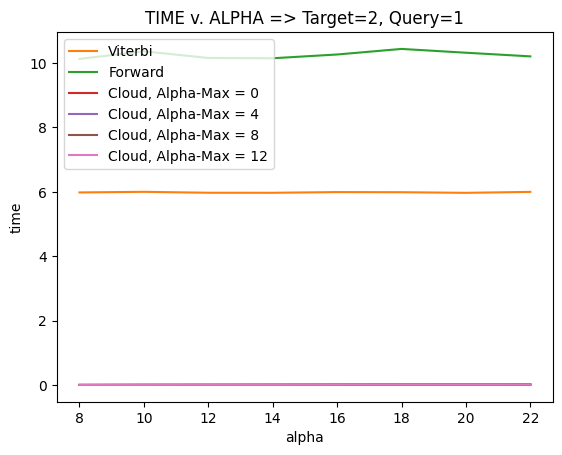

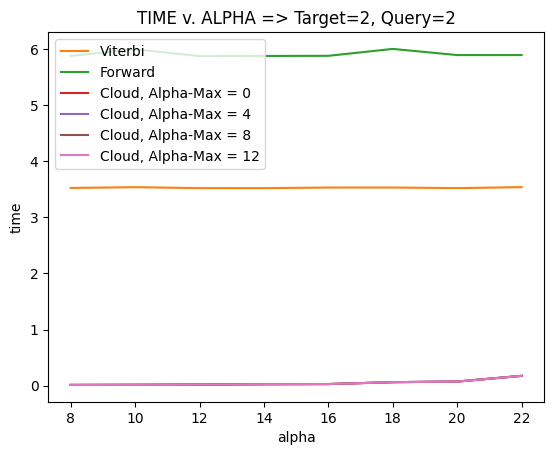

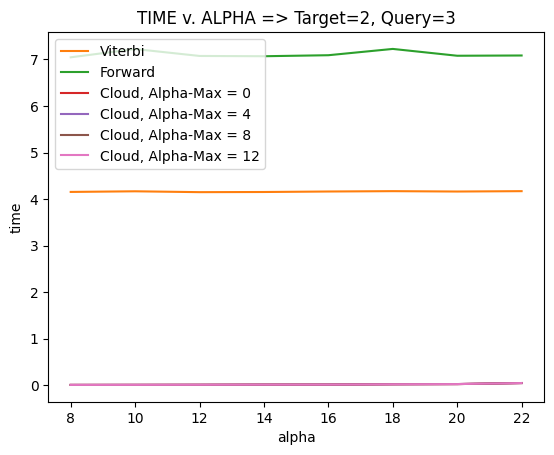

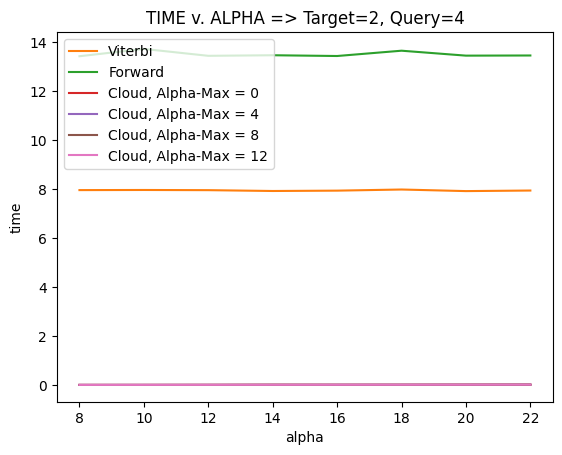

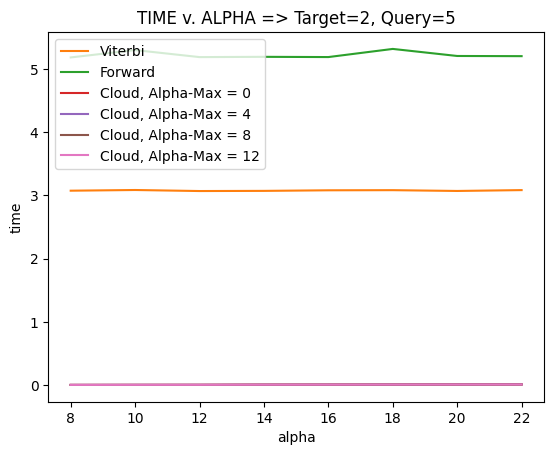

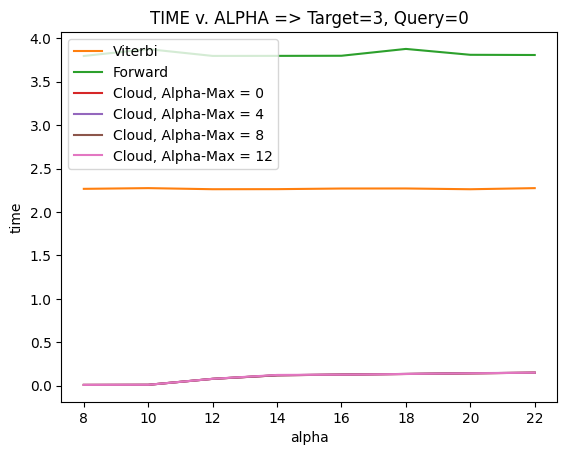

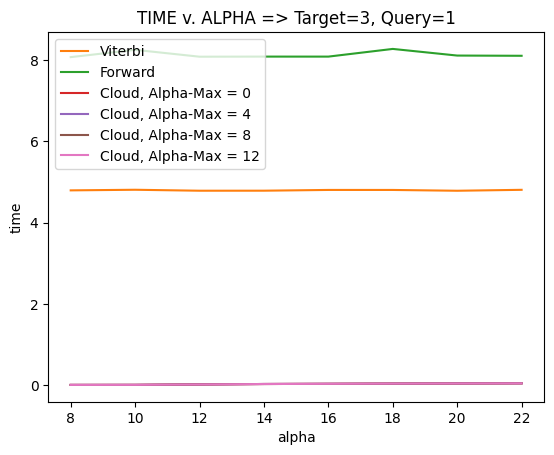

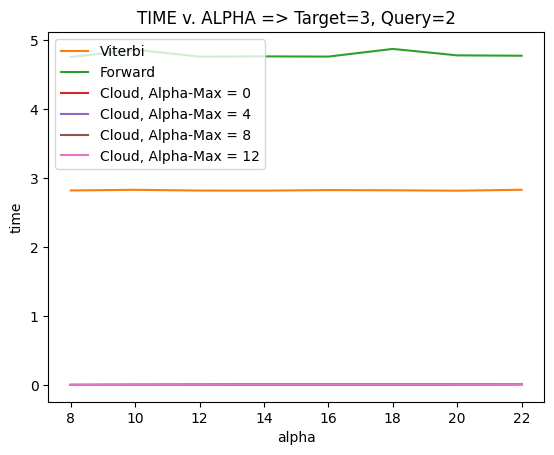

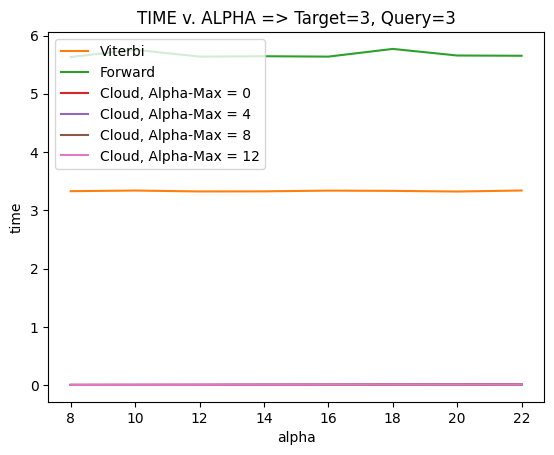

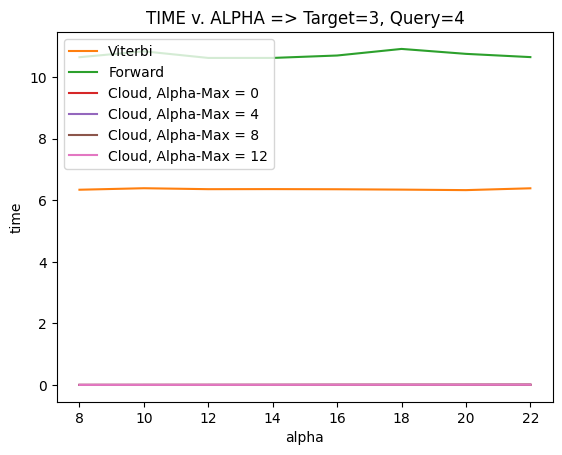

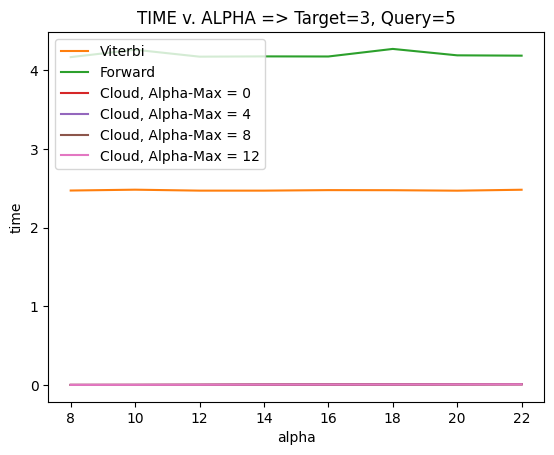

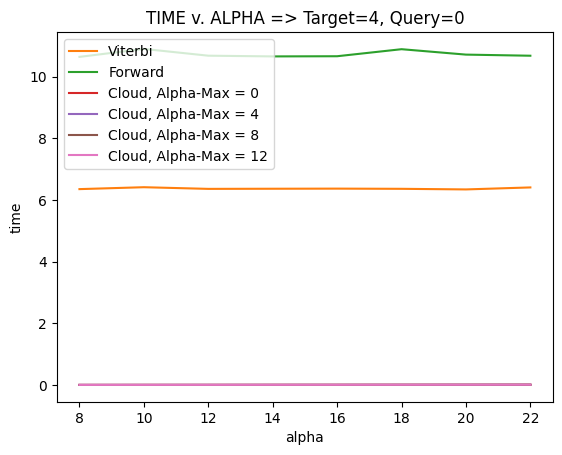

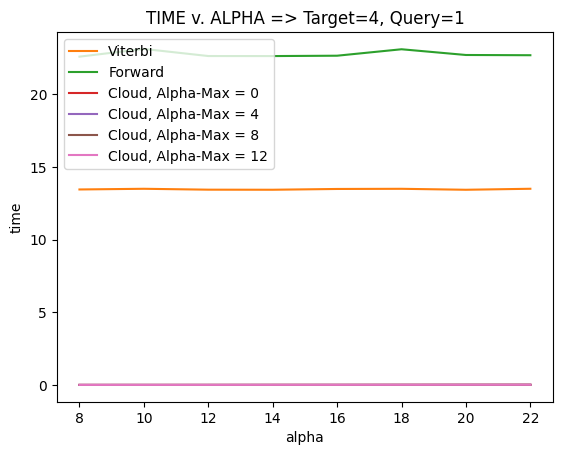

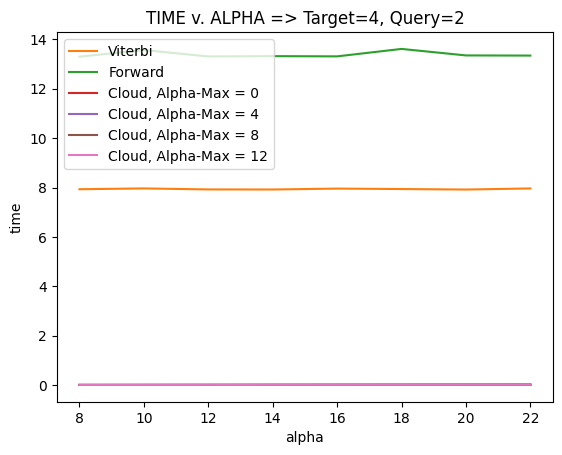

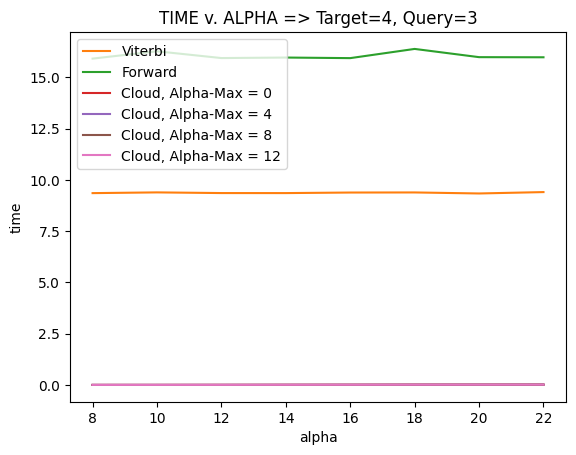

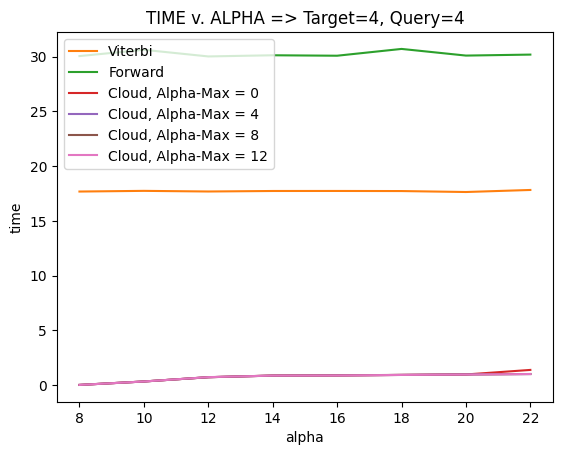

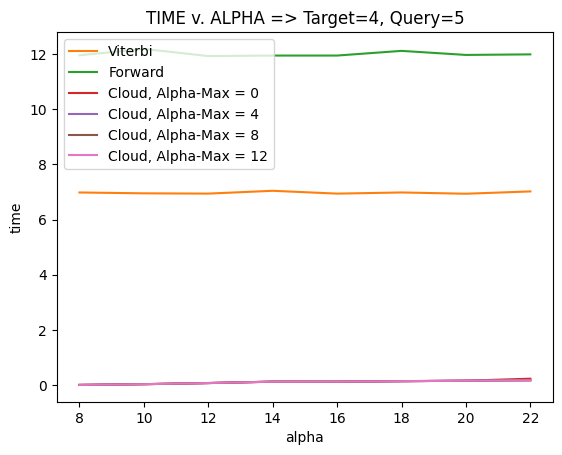

In [11]:
# PLOT: time v. alpha
mpl.style.use('default')

p_id = 3

for p_id in range(len(pair_ids)):
    pair = pair_ids[p_id]
    c = 2
    colors = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
    i = 0

    plt.plot( alphas, vit_tm[pair_ids[p_id]][max_drops[0]], 'C1', label='Viterbi' )
    plt.plot( alphas, fwd_tm[pair_ids[p_id]][max_drops[0]], 'C2', label='Forward' )
    for max_drop in max_drops:
        plt.plot( alphas, cld_tm[pair_ids[p_id]][max_drop], colors[c], label='Cloud, Alpha-Max = {}'.format(max_drop) )
        c += 1

    plt.title('TIME v. ALPHA => Target={}, Query={}'.format(pair[0],pair[1]))
    plt.legend(loc='upper left')
    plt.xlabel('alpha')
    plt.ylabel('time')
    plt.show()